In [1]:
import gurobipy as gp
import math
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import numpy as np
import pandas as pd
import re
import os
import shutil

In [ ]:
# output generation for paper 2

In [2]:
# get input paths
test_set = "quick"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
seed_idxs = [0]  
max_indices = 11
degrees = [0, 2, 4]
term_list = [4, 64]
filter_cbc = False
max_base_std = 1e10
min_termination_time = 1
short, medium, long = 60, 600, 3600
remove_status_changes = False
win_threshold = .1

generators = ["None", "New", "Farkas", "All", "NoDisjunction", "NoMatrix", "NoTerm", "NoBasis"]

# set up some mappings
cat_map_new_lines = {
    "None": "Default",
    "Farkas": "Param Disj,\nParam Cuts",
    "Old": "Param Disj,\nCalc Cuts",
    "New": "Calc Disj,\nCalc Cuts"
}
cat_map = {
    "None": "Default",
    "Farkas": "Param Disj, Param Cuts",
    "Old": "Param Disj, Calc Cuts",
    "New": "Calc Disj, Calc Cuts"
}
perturbation_map = {
    "matrix": "Coefficient Matrix",
    "rhs": "Right Hand Side",
    "bounds": "Variable Bounds",
    "objective": "Objective"
}
label = {
    "postRootTime": "Time after Processing Root nodes",
    "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
    "terminationTimeSansVpc": "Time (Minus VPC Generation)",
    "terminationTime": "Time",
    "nodes": "Nodes Processed",
    "iterations": "LP iterations",
}
unit = {
    "postRootTime": "(seconds)",
    "rootDualBoundTimeSansVpc": "(seconds)",
    "terminationTimeSansVpc": "(seconds)",
    "terminationTime": "(seconds)",
    "nodes": "(1000 nodes)",
    "iterations": "(1000 iterations)",
}
limits = {
    "postRootTime": 7200,
    "terminationTimeSansVpc": 7200,
    "terminationTime": 7200,
    "rootDualBoundTimeSansVpc": 5,
    "nodes": 10000,
    "iterations": 37500
}
bracket_bounds = {
    "short": (min_termination_time, short),
    "medium": (short, medium),
    "long": (medium, long)
}
param_map = {
    "degree": "Degree of Perturbation",
    "terms": "Number of Disjunctive Terms",
}

In [3]:
# matplotlib settings
plt.rc('text', usetex=True)  # use latex fonts
plt.rcParams['font.size'] = 18
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14

## Check run failures

In [4]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         # shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [5]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent nodes": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "solver not proven optimal for nodes": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
    "size of our disjunction is not what we expected it to be": [],
    "dimension must stay fixed": [],
    "vpcgenerator must be": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols, density = {}, {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
    density[instance] = mdl.NumNZs / (mdl.NumConstrs * mdl.NumVars)
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in generators:
                for seed_idx in seed_idxs:

                    # set variables for this iterations
                    count_series += 1
                    stem = f"{instance}_{perturbation}_{terms}_{generator}_{seed_idx}"
                    file_pth = os.path.join(results_fldr, f"{stem}.err")
                    series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                    current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                    count_instances += current_count
                    names[stem] = instance
                    number_instances[stem] = {
                        "expected": current_count,
                        "recorded": 0,
                        "generator": generator,
                        "error": "N/A"
                    }
    
                    # check if the series wasn't run
                    if not os.path.exists(file_pth):
                        number_instances[stem]["error"] = "no go"
                        no_go.append(stem)
                    
                    # check if the series ran with no errors or warnings
                    elif os.path.getsize(file_pth) == 0:
                        number_instances[stem]["error"] = "empty"
                        empty.append(stem)
                    
                    # track which error codes were thrown
                    else:
                        # read the file
                        with open(file_pth, "r") as f:
                            text = f.read().lower()
                        
                        # assign the error file to the appropriate list
                        found_code = False
                        for code in err:
                            if code in text:
                                if code == "dot product with obj differs from solver":
                                    pattern = r"obj viol from solver: (-?\d+\.\d+)\. calculated: (-?\d+\.\d+)"
                                    s, c = re.findall(pattern, text)[-1]
                                    # if we didn't terminate, this isn't an error, so keep going
                                    if abs(float(s) - float(c)) < 1e-3:
                                        continue
                                err[code].append(stem)
                                found_code = True
                                number_instances[stem]["error"] = code
                                break
                        if not found_code:
                            if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                                warning.append(stem)
                                number_instances[stem]["error"] = "warning"
                            else:
                                other.append(stem)
                                number_instances[stem]["error"] = "other"

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Read MPS format model from file instances/quick/neos-574665.mps
Reading time = 0.01 seconds
neos-574665: 3790 rows, 740 columns, 16792 nonzeros
Read MPS format model from file instances/quick/ran13x13.mps
Reading time = 0.00 seconds
ran13x13: 195 rows, 338 columns, 676 nonzeros
Read MPS format model from file instances/quick/neos-1582420.mps
Reading time = 0.01 seconds
neos-1582420: 10180 rows, 10100 columns, 24814 nonzeros
Read MPS format model from file instances/quick/mtest4ma.mps
Reading time = 0.00 seconds
mtest4ma: 1174 rows, 1950 columns, 4875 nonzeros
Read MPS format model from file instances/quick/seymour1.mps
Reading time = 0.01 seconds
seymour1: 4944 rows, 1372 columns, 33549 nonzeros
Read MPS format model from file instances/quick/ic97_tension.mps
Reading time = 0.00 seconds
ic97_tension: 319 rows, 703 columns, 2070 nonzeros
Read MPS format model from file instances/quick/bppc8-09.mps

In [6]:
# check which series didn't run
print(no_go)

[]


In [7]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

1.0

In [8]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

[]


0.0

In [9]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"])
len(err["bad_alloc"] + err["out of memory"]) / count_series

['mtest4ma_objective_0_64_New_0', 'h50x2450_objective_0_64_New_0', 'h50x2450_objective_0_64_Farkas_0', 'h50x2450_objective_2_64_New_0', 'neos-5051588-culgoa_objective_0_64_New_0', 'neos-5051588-culgoa_objective_2_64_New_0', 'neos-5051588-culgoa_objective_4_64_New_0', 'blp-ir98_rhs_0_64_New_0', 'blp-ir98_rhs_0_64_Farkas_0', 'blp-ir98_objective_0_64_New_0', 'blp-ir98_objective_0_64_Farkas_0', 'blp-ir98_objective_2_64_New_0', 'blp-ir98_objective_2_64_Farkas_0', 'blp-ir98_objective_4_64_New_0', 'blp-ir98_objective_4_64_Farkas_0', 'neos-480878_objective_0_64_New_0', 'neos-480878_objective_2_64_New_0', 'neos18_matrix_0_64_New_0', 'neos18_objective_0_64_New_0', 'neos18_objective_2_64_New_0', 'neos18_objective_4_64_New_0', 'neos-4650160-yukon_objective_0_64_New_0', 'roll3000_objective_0_64_New_0', 'roll3000_objective_2_64_New_0', 'roll3000_objective_4_64_New_0', 'g200x740_objective_0_64_New_0', 'g200x740_objective_2_64_New_0', 'aflow30a_objective_0_64_New_0', 'neos-860300_rhs_0_64_New_0', 'neo

0.0077887537993920975

In [10]:
# rerun this if want to give more memory to some instances
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [11]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [12]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [13]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

[]


0.0

In [14]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

[]


0.0

In [15]:
# seg_err = {
#     "Bad image at line": [],
# }
# 
# seg_other = []
# 
# for stem in err["segmentation fault"]:
#     file_pth = os.path.join(results_fldr, f"{stem}.out")
# 
#     with open(file_pth, "r") as f:
#         text = f.read()
#     
#     # assign the error file to the appropriate list
#     found_code = False
#     for code in seg_err:
#         if code in text:
#             seg_err[code].append(stem)
#             found_code = True
#             break
#     if not found_code:
#         seg_other.append(stem)

In [16]:
# print(seg_err["Bad image at line"])
# len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

In [17]:
# print(seg_other)
# len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

In [18]:
# # get breakdown of why vpc generation failed - mostly from lack of provisioning
# for code, exps in seg_err.items():
#     print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")
# 
# print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

In [19]:
# todo: check aleks' removals and drop those below for similar reasons
# todo: check size of disjunctions and decide what to do with those that are too big
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')

['neos-1582420_rhs_0_64_New_0', 'neos-1582420_rhs_0_64_Farkas_0', 'neos-1582420_rhs_0_64_All_0', 'neos-1582420_rhs_0_64_NoDisjunction_0', 'neos-1582420_rhs_0_64_NoMatrix_0', 'neos-1582420_rhs_0_64_NoTerm_0', 'neos-1582420_rhs_0_64_NoBasis_0', 'neos-1582420_matrix_0_64_New_0', 'neos-1582420_matrix_0_64_Farkas_0', 'neos-1582420_matrix_0_64_All_0', 'neos-1582420_matrix_0_64_NoDisjunction_0', 'neos-1582420_matrix_0_64_NoMatrix_0', 'neos-1582420_matrix_0_64_NoTerm_0', 'neos-1582420_matrix_0_64_NoBasis_0', 'neos-1582420_objective_0_64_New_0', 'neos-1582420_objective_0_64_Farkas_0', 'neos-1582420_objective_0_64_All_0', 'neos-1582420_objective_0_64_NoDisjunction_0', 'neos-1582420_objective_0_64_NoMatrix_0', 'neos-1582420_objective_0_64_NoTerm_0', 'neos-1582420_objective_0_64_NoBasis_0', 'neos-1582420_rhs_4_64_New_0', 'neos-1582420_rhs_4_64_Farkas_0', 'neos-1582420_rhs_4_64_All_0', 'neos-1582420_rhs_4_64_NoDisjunction_0', 'neos-1582420_rhs_4_64_NoMatrix_0', 'neos-1582420_rhs_4_64_NoTerm_0', 'ne

In [20]:
# vpc_err = {
#     "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
#     "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
#     "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
#     "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
#     "CglVPC: Finishing with exit reason: SUCCESS": [],
#     "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
#     "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
#     "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
# }
# 
# vpc_other = []
# 
# for stem in err["no vpcs were made from a new disjunction"]:
#     file_pth = os.path.join(results_fldr, f"{stem}.out")
# 
#     with open(file_pth, "r") as f:
#         text = f.read()
#     
#     # assign the error file to the appropriate list
#     found_code = False
#     for code in vpc_err:
#         if code in text:
#             vpc_err[code].append(stem)
#             found_code = True
#             break
#     if not found_code:
#         vpc_other.append(stem)

In [21]:
# print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

In [22]:
# print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

In [23]:
# print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

In [24]:
# print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

In [25]:
# print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

In [26]:
# print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

In [27]:
# print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

In [28]:
# print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

In [29]:
# vpc_other

In [30]:
# # get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
# if err["no vpcs were made from a new disjunction"]:
#     for code, exps in vpc_err.items():
#         print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")
#     
#     print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

In [31]:
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

[]


0.0

In [32]:
# LP relaxation objective is not going to match root nodes objective when warm starting 
print(err["objective at parent nodes"])
len(err["objective at parent nodes"]) / count_series

[]


0.0

In [33]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

[]


0.0

In [34]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

[]


0.0

In [35]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for nodes"])
len(err["solver not proven optimal for nodes"]) / count_series

[]


0.0

In [36]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [37]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [38]:
print(warning)
len(warning) / count_series

['neos-1582420_matrix_0_4_New_0', 'neos-1582420_matrix_0_4_Farkas_0', 'bppc8-09_rhs_2_64_New_0', 'neos-5051588-culgoa_objective_4_64_Farkas_0', 'aligninq_objective_0_4_New_0', 'aligninq_objective_2_4_New_0', 'aligninq_objective_4_4_New_0', 'gsvm2rl3_rhs_0_4_New_0', 'gsvm2rl3_rhs_2_64_New_0', 'neos-631517_objective_0_4_New_0', 'neos-631517_objective_2_64_New_0', 'rout_objective_0_4_New_0', 'rout_objective_0_4_Farkas_0', 'rout_objective_0_64_New_0', 'rout_objective_2_4_New_0', 'rout_objective_2_4_Farkas_0', 'rout_objective_4_4_New_0', 'rout_objective_4_4_Farkas_0', 'rout_objective_4_64_New_0', 'bienst1_objective_0_4_New_0', 'bienst1_objective_0_4_Farkas_0', 'bienst1_objective_0_64_New_0', 'bienst1_objective_2_4_New_0', 'bienst1_objective_2_4_Farkas_0', 'bienst1_objective_2_64_New_0', 'bienst1_objective_4_4_New_0', 'bienst1_objective_4_4_Farkas_0', 'bienst1_objective_4_64_New_0', 'neos-480878_objective_0_4_New_0', 'neos-911970_objective_4_64_New_0', 'neos-4650160-yukon_objective_0_4_New_0

0.0077887537993920975

In [39]:
# errors unaccounted for
print(other)
len(other) / count_series

['gsvm2rl3_rhs_0_64_New_0', 'gsvm2rl3_rhs_4_64_New_0', 'eil33-2_matrix_0_64_New_0', 'eil33-2_matrix_0_64_Farkas_0', 'eil33-2_matrix_0_64_All_0', 'eil33-2_matrix_0_64_NoDisjunction_0', 'eil33-2_matrix_0_64_NoMatrix_0', 'eil33-2_matrix_0_64_NoTerm_0', 'eil33-2_matrix_0_64_NoBasis_0', 'eil33-2_objective_0_64_New_0', 'eil33-2_objective_0_64_Farkas_0', 'eil33-2_objective_0_64_All_0', 'eil33-2_objective_0_64_NoDisjunction_0', 'eil33-2_objective_0_64_NoMatrix_0', 'eil33-2_objective_0_64_NoTerm_0', 'eil33-2_objective_0_64_NoBasis_0', 'eil33-2_rhs_4_64_New_0', 'eil33-2_rhs_4_64_Farkas_0', 'eil33-2_rhs_4_64_All_0', 'eil33-2_rhs_4_64_NoDisjunction_0', 'eil33-2_rhs_4_64_NoMatrix_0', 'eil33-2_rhs_4_64_NoTerm_0', 'eil33-2_rhs_4_64_NoBasis_0', 'eil33-2_objective_2_64_New_0', 'eil33-2_objective_2_64_Farkas_0', 'eil33-2_objective_2_64_All_0', 'eil33-2_objective_2_64_NoDisjunction_0', 'eil33-2_objective_2_64_NoMatrix_0', 'eil33-2_objective_2_64_NoTerm_0', 'eil33-2_objective_2_64_NoBasis_0', 'eil33-2_mat

0.01006838905775076

In [40]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"])) / count_series

0.0077887537993920975

In [41]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

['neos-480878_objective_2_4_New_0', 'neos-480878_objective_4_4_New_0', 'neos-480878_objective_4_64_New_0']


0.0005699088145896656

In [42]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [43]:
# largely not replicating - only issue I could find was aleks missing updated objective from CLP when resolving to check this
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

[]


0.0

In [44]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

[]


0.0

In [45]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

[]


0.0

In [46]:
print(err["size of our disjunction is not what we expected it to be"])
len(err["size of our disjunction is not what we expected it to be"]) / count_series

[]


0.0

In [47]:
print(err["vpcgenerator must be"])
len(err["vpcgenerator must be"]) / count_series

['neos-574665_objective_2_4_All_0', 'neos-574665_objective_2_4_NoDisjunction_0', 'neos-574665_objective_2_4_NoMatrix_0', 'neos-574665_objective_2_4_NoTerm_0', 'neos-574665_objective_2_4_NoBasis_0', 'neos-574665_objective_2_64_All_0', 'neos-574665_objective_2_64_NoDisjunction_0', 'neos-574665_objective_2_64_NoMatrix_0', 'neos-574665_objective_2_64_NoTerm_0', 'neos-574665_objective_2_64_NoBasis_0', 'ran13x13_matrix_0_4_All_0', 'ran13x13_matrix_0_4_NoDisjunction_0', 'ran13x13_matrix_0_4_NoMatrix_0', 'ran13x13_matrix_0_4_NoTerm_0', 'ran13x13_matrix_0_4_NoBasis_0', 'ran13x13_matrix_0_64_All_0', 'ran13x13_matrix_0_64_NoDisjunction_0', 'ran13x13_matrix_0_64_NoMatrix_0', 'ran13x13_matrix_0_64_NoTerm_0', 'ran13x13_matrix_0_64_NoBasis_0', 'ran13x13_objective_0_4_All_0', 'ran13x13_objective_0_4_NoDisjunction_0', 'ran13x13_objective_0_4_NoMatrix_0', 'ran13x13_objective_0_4_NoTerm_0', 'ran13x13_objective_0_4_NoBasis_0', 'ran13x13_objective_0_64_All_0', 'ran13x13_objective_0_64_NoDisjunction_0', 'ra

0.14532674772036475

In [48]:
print(err["dimension must stay fixed"])
len(err["dimension must stay fixed"]) / count_series

['neos-574665_rhs_0_4_New_0', 'neos-574665_rhs_0_4_Farkas_0', 'neos-574665_rhs_0_4_All_0', 'neos-574665_rhs_0_4_NoDisjunction_0', 'neos-574665_rhs_0_4_NoMatrix_0', 'neos-574665_rhs_0_4_NoTerm_0', 'neos-574665_rhs_0_4_NoBasis_0', 'neos-574665_rhs_0_64_New_0', 'neos-574665_rhs_0_64_Farkas_0', 'neos-574665_rhs_0_64_All_0', 'neos-574665_rhs_0_64_NoDisjunction_0', 'neos-574665_rhs_0_64_NoMatrix_0', 'neos-574665_rhs_0_64_NoTerm_0', 'neos-574665_rhs_0_64_NoBasis_0', 'neos-574665_matrix_0_4_New_0', 'neos-574665_matrix_0_4_Farkas_0', 'neos-574665_matrix_0_4_All_0', 'neos-574665_matrix_0_4_NoDisjunction_0', 'neos-574665_matrix_0_4_NoMatrix_0', 'neos-574665_matrix_0_4_NoTerm_0', 'neos-574665_matrix_0_4_NoBasis_0', 'neos-574665_matrix_0_64_New_0', 'neos-574665_matrix_0_64_Farkas_0', 'neos-574665_matrix_0_64_All_0', 'neos-574665_matrix_0_64_NoDisjunction_0', 'neos-574665_matrix_0_64_NoMatrix_0', 'neos-574665_matrix_0_64_NoTerm_0', 'neos-574665_matrix_0_64_NoBasis_0', 'neos-574665_objective_0_4_New_

0.5288753799392097

In [49]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.0
bad_alloc: 0.0077887537993920975
out of memory: 0.0
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.0
segmentation fault: 0.0
no vpcs were made from a new disjunction: 0.09840425531914894
must have primalbound >= root lp objective: 0.0
objective at parent nodes: 0.0
failed to optimize mip: 0.0
disjunction does not represent a full binary tree: 0.0
solver not proven optimal for nodes: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 0.0005699088145896656
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.0
unable to read file: 0.0
stats.id == stats_vec: 0.0
size of our disjunction is not what we expected it to be: 0.0
dimension must stay fixed: 0.5288753799392097
vpcgenerator must be: 0.14532674772036475
other: 0.01006838905775076
no errors/warnings: 0.20117781155015196
no go: 0.0


## Read in data

In [49]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')
solution_pattern = r"_(\d+)\.pb"

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()
primal_bounds = {}
same_solution = {}

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    instance_name = match.group(1)
    perturbation = match.group(2)
    expo = int(match.group(3))
    degree = 2**int(expo)
    terms = int(match.group(4))
    generator = match.group(5)
    base_name = f"{instance_name}_0"
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{expo}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[perturbation, expo, ".".join(test_set_file.split(".")[:-1])] = float(f.read())
                
    # see if solution changed
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            perturbation_name = ".".join(test_set_file.split(".")[:-1])
            same_solution[perturbation, expo, perturbation_name] = \
                primal_bounds[perturbation, expo, base_name] == primal_bounds[perturbation, expo, perturbation_name]
            
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(
            primal_bounds[perturbation, expo, f"{instance_name}_{instance_idx}"], df.loc[instance_idx, "primalBound"]
        )
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    df["rows"] = rows[instance_name]
    df["cols"] = cols[instance_name]
    df["density"] = density[instance_name]
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [50]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame.head()

,expected,recorded,generator,error
f2gap201600_rhs_-1_4_None_0,201,201,None,empty
f2gap201600_rhs_-1_4_New_0,201,185,New,empty
f2gap201600_rhs_-1_4_Old_0,201,201,Old,empty
f2gap201600_rhs_-1_4_Farkas_0,201,201,Farkas,empty
f2gap201600_rhs_-1_16_None_0,201,201,None,empty


In [51]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [52]:
if "miplib" in test_set:
    # group frame by generator and sum remaining columns
    gb = frame.groupby(["generator", "error"]).sum().reset_index()
    gb["missing"] = gb["expected"] - gb["recorded"]
    total = gb.groupby("generator")[["expected", "missing"]].sum().reset_index()
    gb = pd.merge(gb, total, on="generator", suffixes=("", " total"))
    gb["ratio missing (by generator)"] = gb["missing"] / gb["missing total"]
    gb["ratio missing (by generator)"] = gb["ratio missing (by generator)"].apply(lambda x: round(x, 4))
    gb = gb.loc[:, ~gb.columns.str.contains("total")]  # get rid of the total columns
    gb.set_index(["generator", "error"], inplace=True)
    gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
else:
    gb = None
gb

In [53]:
for gen in ["None", "New", "Old", "Farkas"]:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas"),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.0
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Old 0: 0.0
Old 1: 0.0
Old 2: 0.0
Old 3: 0.0
Old 4: 0.0
Old 5: 0.0
Old 6: 0.0
Old 7: 0.0
Old 8: 0.0
Old 9: 0.0
Old 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.0
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0


In [54]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map["Farkas"][masks[0]]

,instanceIndex,seedIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,...,providePrimalBound,infeasibleTerms,feasibleToInfeasibleTerms,infeasibleToFeasibleTerms,instance,perturbation,degree,rows,cols,density


In [55]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0
Farkas: 0.0
New: 0.0
Old: 0.0


In [56]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex", "seedIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df.head()

,instanceIndex,seedIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,...,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas,infeasibleTerms Farkas,feasibleToInfeasibleTerms Farkas,infeasibleToFeasibleTerms Farkas,rows Farkas,cols Farkas,density Farkas
0,0,0,None,64,76429.862296,76429.862296,76429.862296,76450.507295,76452.0,76453.0,...,16,16,GUROBI,1,0,0,0,20,1600,0.1
1,1,0,None,64,76449.080834,76449.080834,76449.080834,76469.275901,76471.0,76473.0,...,16,0,GUROBI,1,0,0,0,20,1600,0.1
2,10,0,None,64,76411.913790,76411.913790,76411.913790,76433.983069,76435.0,76435.0,...,16,0,GUROBI,1,0,0,0,20,1600,0.1
3,100,0,None,64,76434.778273,76434.778273,76434.778273,76456.656755,76458.0,76458.0,...,16,0,GUROBI,1,0,0,0,20,1600,0.1
4,101,0,None,64,76416.862296,76416.862296,76416.862296,76437.547100,76439.0,76440.0,...,16,0,GUROBI,1,0,0,0,20,1600,0.1


In [57]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.5212824765063571

In [58]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

# Function to map values based on a dictionary
def check_same_solution(row):
    # Create a tuple of the key based on the key_columns
    return same_solution[row["perturbation"], int(math.log2(row["degree"])), f'{row["instance"]}_{row["instanceIndex"]}']

In [59]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

In [60]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["terminationTimeSansVpcImprovement"] = (df["terminationTimeSansVpc None"] - df["terminationTimeSansVpc Farkas"]) / df["terminationTimeSansVpc None"]
df["nodesImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationsImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 
df["terminationTimeRatio"] = df["terminationTime Farkas"] / df["terminationTime None"]
df["terminationTimeSansVpcRatio"] = df["terminationTimeSansVpc Farkas"] / df["terminationTimeSansVpc None"]
df["nodesRatio"] = df["nodes Farkas"] / df["nodes None"] 
df["iterationsRatio"] = df["iterations Farkas"] / df["iterations None"]
df["nodesImproves"] = df["nodes None"] > df["nodes Farkas"]
df["terminationTimeImproves"] = df["terminationTime None"] > df["terminationTime Farkas"]
df["terminationTimeSansVpcImproves"] = df["terminationTimeSansVpc None"] > df["terminationTimeSansVpc Farkas"]
df["iterationsImproves"] = df["iterations None"] > df["iterations Farkas"]
df['nodesWinFarkas'] = df['nodes None']*(1 - win_threshold) > df['nodes Farkas']
df['terminationTimeWinFarkas'] = df['terminationTime None']*(1 - win_threshold) > df['terminationTime Farkas']
df['terminationTimeSansVpcWinFarkas'] = df['terminationTimeSansVpc None']*(1 - win_threshold) > df['terminationTimeSansVpc Farkas']
df['iterationsWinFarkas'] = df['iterations None']*(1 - win_threshold) > df['iterations Farkas']
df['nodesWinNone'] = df['nodes Farkas']*(1 - win_threshold) > df['nodes None']
df['terminationTimeWinNone'] = df['terminationTime Farkas']*(1 - win_threshold) > df['terminationTime None']
df['terminationTimeSansVpcWinNone'] = df['terminationTimeSansVpc Farkas']*(1 - win_threshold) > df['terminationTimeSansVpc None']
df['iterationsWinNone'] = df['iterations Farkas']*(1 - win_threshold) > df['iterations None']
df["bracket"] = ["short" if t <= short else "medium" if t <= medium else "long" for t in df["terminationTime None"]]
df["sameSolution"] = df.apply(check_same_solution, axis=1)

In [61]:
# get sensitivity stats as ratios
for gen_name in ["New", "Old", "Farkas"]:
    df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"zeroInfeasibleToFeasibleTerms {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] == 0
    df[f"feasibleToInfeasibleTermsRatio {gen_name}"] = df[f"feasibleToInfeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]

In [62]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [63]:
# aleks filters
# df = df.loc[df["terms"] == df["actualTerms Farkas"]]
# df = df.loc[df["zeroInfeasibleToFeasibleTerms Farkas"]]

In [64]:
df.head()

,instanceIndex,seedIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
0,0,0,None,64,76429.862296,76429.862296,76429.862296,76450.507295,76452.0,76453.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
1,1,0,None,64,76449.080834,76449.080834,76449.080834,76469.275901,76471.0,76473.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
2,10,0,None,64,76411.913790,76411.913790,76411.913790,76433.983069,76435.0,76435.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
3,100,0,None,64,76434.778273,76434.778273,76434.778273,76456.656755,76458.0,76458.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
4,101,0,None,64,76416.862296,76416.862296,76416.862296,76437.547100,76439.0,76440.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0


In [65]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "bracket", "degree", "terms"]
id_cols = ["instanceIndex"]

# keep the instance, perturbation, instanceIndex triples that exist for all combinations of degree and terms
# where VPC did not find the optimal solution
full_df = df.loc[df["Disjunction (New)"] < .9999]
triples = (full_df.groupby(
        ["instance", "perturbation", "instanceIndex"]
    ).size().reset_index().rename(columns={0: "count"}))
triples.head()

,instance,perturbation,instanceIndex,count
0,f2gap201600,matrix,0,1
1,f2gap201600,matrix,1,1
2,f2gap201600,matrix,10,1
3,f2gap201600,matrix,100,1
4,f2gap201600,matrix,101,1


In [67]:
# uncomment to filter for only the triples that exist for all combinations of degree and terms (and seed index)
# triples = triples[triples["count"] == len(degrees) * len(term_list) * len(seed_idxs)]
# full_df = full_df.merge(triples, on=["instance", "perturbation", "instanceIndex"])
full_df.to_csv(os.path.join(out_fldr, "cleaned_combined_complete.csv"), index=False, mode="w")

## Check Root Node Stats

In [68]:
def interleave(list_of_lists):
    return [item for sublist in zip(*list_of_lists) for item in sublist]

In [69]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)", "VPCs (Farkas)"] + \
    interleave([[f"Root Cuts ({gen_name})", f"terminationTime {gen_name}", f"nodes {gen_name}",
                 f"iterations {gen_name}", f"terminationTimeSansVpc {gen_name}", f"vpcGenerationTime {gen_name}", 
                 f"rootDualBoundTime {gen_name}"]
                for gen_name in ["None", "New", "Old", "Farkas"]]) + \
    interleave([[f"infeasibleTermsRatio {gen_name}", f"infeasibleToFeasibleTermsRatio {gen_name}",
                 f"zeroInfeasibleToFeasibleTerms {gen_name}", f"feasibleToInfeasibleTermsRatio {gen_name}"]
                for gen_name in ["New", "Old", "Farkas"]]) + \
    ["terminationTimeRatio", "nodesRatio", "iterationsRatio", "sameSolution"]

# now reduce bound_df to just the perturbed instances - make > -1 to include base instance
bound_df = full_df.loc[full_df["instanceIndex"] > 0, group_cols + id_cols + fields]

In [70]:
# reduce rows to max number of unique indices
def filter_max_indices(group):
    # Keep only rows belonging to the first 50 unique `instanceIndex` values
    return group[group['instanceIndex'].isin(group['instanceIndex'].sort_values().unique()[:max_indices])]

# Group by the desired columns and apply the filtering
bound_df = bound_df.groupby(['instance', 'perturbation', 'degree', 'terms'], group_keys=False).apply(filter_max_indices)

In [74]:
def geometric_mean(series, offset=1e-6):
    adjusted_series = series + offset  # Add a small offset to avoid zeros
    return np.exp(np.log(adjusted_series).mean())

# paper currently uses mean, but we can switch to geometric mean if we want
aggregations = {f: geometric_mean if f not in ["sameSolution"] else "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [75]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),...,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodesRatio,iterationsRatio,sameSolution,instance,instanceIndex
0,0.5,4,0.056523,0.055422,0.037280,0.037517,0.010182,0.848348,0.827198,0.826548,...,1.000001,0.000001,0.000001,0.000001,0.954379,0.592395,0.914571,0.242820,1,383
1,0.5,16,0.061792,0.059638,0.055047,0.052302,0.048106,0.844304,0.826263,0.825907,...,1.000001,0.000001,0.000001,0.000001,1.121646,0.582210,0.939021,0.247475,1,396
2,0.5,64,0.073931,0.068893,0.064481,0.057119,0.050057,0.868001,0.846013,0.845471,...,1.000001,0.000001,0.000001,0.000001,1.914128,0.462252,0.864463,0.197452,1,157


In [76]:
# now break it down by type of perturbation
out = bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table_by_perturbation.csv"), index=False, mode="w")
out

,degree,terms,perturbation,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),...,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodesRatio,iterationsRatio,sameSolution,instance,instanceIndex
0,0.5,4,matrix,0.015358,0.015386,0.010157,0.010710,0.000001,0.656308,0.628582,...,1.000001,0.000001,0.000001,0.000001,1.134290,1.123381,1.142436,0.000000,1,4
1,0.5,4,objective,0.068636,0.066219,0.049221,0.053946,0.012721,0.919723,0.890300,...,1.000001,0.000001,0.000001,0.000001,0.973272,0.558226,0.920959,0.030769,1,195
2,0.5,4,rhs,0.047333,0.047190,0.028568,0.026237,0.009829,0.783100,0.769780,...,1.000001,0.000001,0.000001,0.000001,0.931255,0.622176,0.903470,0.472826,1,184
3,0.5,16,objective,0.075105,0.070231,0.065452,0.060014,0.057991,0.918276,0.891970,...,1.000001,0.000001,0.000001,0.000001,1.183081,0.502266,0.919992,0.030612,1,196
4,0.5,16,rhs,0.051038,0.050808,0.046456,0.045706,0.040056,0.777595,0.766569,...,1.000001,0.000001,0.000001,0.000001,1.064536,0.672886,0.958050,0.460000,1,200
5,0.5,64,objective,0.083280,0.074499,0.073298,0.061881,0.055523,0.916734,0.893043,...,1.000001,0.000001,0.000001,0.000001,2.113879,0.374609,0.795339,0.048544,1,103
6,0.5,64,rhs,0.058911,0.059343,0.050496,0.049028,0.041078,0.782115,0.763066,...,1.000001,0.000001,0.000001,0.000001,1.583959,0.690282,1.013406,0.481481,1,54


In [74]:
# now just rows of out where degree is .5 and terms are 4
# now reduce bound_df to just the perturbed instances - make > -1 to include base instance
complete_time_df = full_df[group_cols + id_cols + fields]

# keep only max number of repeats if desired
complete_time_df = complete_time_df.groupby(['instance', 'perturbation', 'degree', 'terms'], group_keys=False).apply(filter_max_indices)

# pare down above table to just summary statistics
complete_time_df = complete_time_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
complete_time_df = complete_time_df.loc[
    (complete_time_df["degree"] == .5) & (complete_time_df["terms"] == 4),
    ["perturbation", "terminationTime None", "terminationTime New", "terminationTime Old", "terminationTime Farkas", 
     "sameSolution", "instanceIndex"]
]

# get total termination time
for gen in ["None", "New", "Old", "Farkas"]:
    complete_time_df[f"terminationTime {gen}"] = complete_time_df[f"terminationTime {gen}"] * complete_time_df["instanceIndex"]

# set perturbation as the index
complete_time_df.set_index("perturbation", inplace=True)

# add a row that is the average of the other rows and name its perturbation "average"
complete_time_df.loc['Average'] = complete_time_df.mean()
complete_time_df[complete_time_df.columns[:-1]]

,terminationTime None,terminationTime New,terminationTime Old,terminationTime Farkas,sameSolution
perturbation,,,,,
matrix,74.108339,81.032207,70.802948,63.657291,1.000000
objective,72.202151,80.814652,73.897849,72.886252,0.440000
rhs,76.732552,81.174689,70.664320,62.156320,1.000000
Average,74.347681,81.007183,71.788372,66.233288,0.813333


In [95]:
def make_pareto_frontier(bound_df, save_fig = True):

    pareto_df = bound_df[[f for f in fields if "Root Cuts" in f or "rootDualBoundTime" in f]].apply(geometric_mean).reset_index()
    pareto_df.columns = ["key", "value"]
    
    # Extract strength and time rows
    strength_df = pareto_df[pareto_df['key'].str.contains("Root Cuts")].copy()
    strength_df['category'] = strength_df['key'].str.extract(r'\((.*?)\)')
    # strength_df["value"] = 100 * strength_df["value"]
    
    time_df = pareto_df[pareto_df['key'].str.contains("rootDualBoundTime")].copy()
    time_df['category'] = time_df['key'].str.extract(r'(None|Farkas|Old|New)')
    
    # Merge data on category
    merged_df = pd.merge(strength_df, time_df, on='category', suffixes=('_strength', '_time'))
    
    # update column names
    merged_df['category'] = merged_df['category'].replace(cat_map_new_lines)
    
    # Create plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['value_strength'], merged_df['value_time'], color='blue', label='Data Points')
    plt.xlabel("Average Root nodes Optimality Gap Closed")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0, 1))
    plt.ylabel("Average Time (s) to Process Root nodes")
    plt.title("Root nodes Optimality Gap Closed vs. Processing Time")
    plt.grid(True)
    
    # Annotate points with categories
    for _, row in merged_df.iterrows():
        offset = (10, -5) if row['category'] == "Default" else (-60, -10) if "Param" not in row["category"] else (-70, -10)
        plt.annotate(row['category'], (row['value_strength'], row['value_time']),
                     textcoords="offset points", xytext=offset, fontsize=14)
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(os.path.join(
            out_fldr, f"strength_vs_time.png"
        ), dpi=1200)
    
    # order merged_df by strength
    print(merged_df.sort_values("value_strength", ascending=True)[["key_strength", "value_strength", "value_time"]])
    
    plt.show()

         key_strength  value_strength  value_time
0    Root Cuts (None)        0.401632    0.118526
3  Root Cuts (Farkas)        0.493261    0.129379
2     Root Cuts (Old)        0.508308    0.178960
1     Root Cuts (New)        0.508432    0.260163


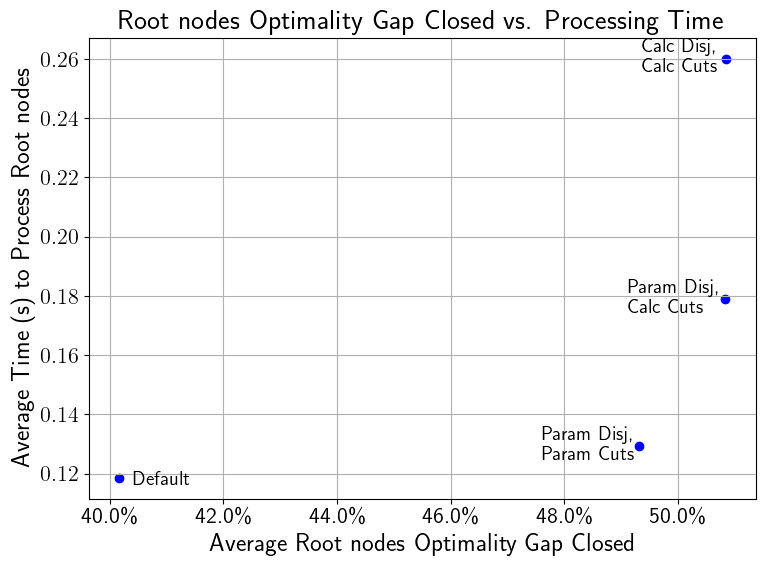

In [96]:
make_pareto_frontier(bound_df)

## Check Termination Stats

In [97]:
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = (df["Disjunction (New)"] < .9999) & (df["instanceIndex"] > 0) & (optimality_gap(df, "New") <= 1e-4) & \
    (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4) & \
       (df["terminationTime None"] > min_termination_time)
if remove_status_changes:
    mask = mask & (df["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (df["feasibleToInfeasibleTermsRatio Farkas"] == 0)

gap_df = df.loc[mask]

In [98]:
gap_df.head()

,instanceIndex,seedIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
1,1,4,None,4,21.201484,21.201484,21.201484,26.409019,34.0,34.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
2,2,4,None,4,20.570922,20.570922,20.570922,25.259724,34.0,34.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
3,3,4,None,4,20.570922,20.570922,20.570922,26.427088,34.0,34.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
4,4,4,None,4,20.570922,20.570922,20.570922,26.427088,34.0,34.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0
5,5,4,None,4,20.570922,20.570922,20.570922,26.427088,34.0,34.0,...,True,0.0,0.0,0.0,True,0.0,0.0,0.0,True,0.0


In [99]:
def plot_distributions(histogram_df, feature, bins=100, xlim=(-2, 1), perturbation=None, exclude_perturbation=False, title_x=.5):
    """
    Generate a grid of cumulative distribution functions (CDFs) for a given feature,
    one for each combination of terms and degrees.

    :param histogram_df: DataFrame containing the data
    :param feature: The feature to plot (as relative improvement)
    :param bins: Number of bins in each histogram (only for 'pmf')
    :param xlim: Tuple for the x-axis limits
    :param perturbation: Specific perturbation to filter for
    :param exclude_perturbation: If True, excludes the perturbation instead of including it
    """

    # Unique values in 'degree' and 'terms'
    unique_degrees = histogram_df['degree'].sort_values(ascending=False).unique()
    unique_terms = histogram_df['terms'].sort_values().unique()

    # Create subplots for the grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4 * len(unique_terms), 4 * len(unique_degrees)))

    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j] if len(unique_degrees) > 1 and len(unique_terms) > 1 else axes[i] if len(unique_degrees) > 1\
                else axes[j] if len(unique_terms) > 1 else axes

            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = histogram_df[(histogram_df['degree'] == degree) & (histogram_df['terms'] == terms)]

            # Filter or exclude specific perturbation type
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                    else subset_df[subset_df["perturbation"] != perturbation]

            # Compute relative improvements
            relative_improvements = {
                "Farkas": -(subset_df[f"{feature} None"] - subset_df[f"{feature} Farkas"]) / subset_df[f"{feature} None"],
                "New": -(subset_df[f"{feature} None"] - subset_df[f"{feature} New"]) / subset_df[f"{feature} None"],
                "Old": -(subset_df[f"{feature} None"] - subset_df[f"{feature} Old"]) / subset_df[f"{feature} None"]
            }

            # Compute CDFs
            x = np.linspace(xlim[0], xlim[1], bins)
            y_farkas = [(relative_improvements["Farkas"] <= val).sum() / len(relative_improvements["Farkas"]) for val in x]
            y_new = [(relative_improvements["New"] <= val).sum() / len(relative_improvements["New"]) for val in x]
            y_old = [(relative_improvements["Old"] <= val).sum() / len(relative_improvements["Old"]) for val in x]

            ax.plot(x, y_farkas, label=cat_map["Farkas"], color="blue")
            ax.plot(x, y_new, label=cat_map["New"], color="green")
            ax.plot(x, y_old, label=cat_map["Old"], color="orange")

            # Highlight the region where Farkas is better than both New and Old
            fill_region = [y_farkas[k] > max(y_new[k], y_old[k]) for k in range(len(x))]
            ax.fill_between(x, np.maximum(y_new, y_old), y_farkas, where=fill_region,
                            facecolor='yellow', alpha=0.3,
                            label=f'Improvement from\n{cat_map["Farkas"]}')
        
            # Set plot limits and labels
            ax.set_xlim(xlim)
            ax.set_ylim(0, 1)
            ax.set_title(f"{degree} Degree{'s' if degree > 1 else ''}, {terms} Terms")
            if j == 0:
                ax.set_ylabel("Probability")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel("Relative Change")

    # Add a common legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(title_x, -0.05), ncol=5)

    # Adjust layout and add a title
    fig.suptitle(f"CDF of Relative Change in Solve {label[feature]}", x=title_x)
    plt.tight_layout()
    
    # Save the figure with tight layout
    plt.savefig(os.path.join(out_fldr, f"cdf_{feature}.png"), dpi=1200, bbox_inches='tight')

    # Show the plot
    plt.show()

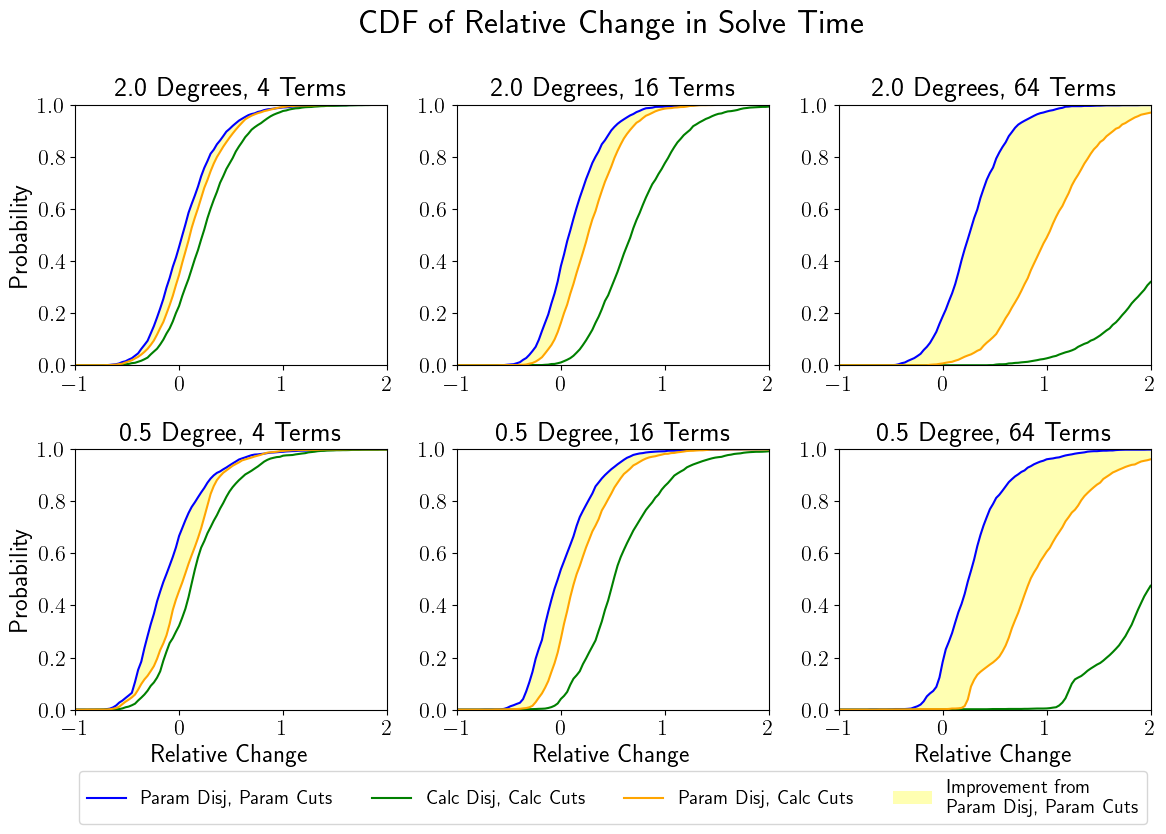

In [100]:
plot_distributions(gap_df, "terminationTime", xlim=(-1, 2), title_x=.525)

In [101]:
def plot_distributions_by_parameter(histogram_df, feature, plot_by='terms', bins=100, xlim=(-1, 2), perturbation=None, exclude_perturbation=False, title_x=.5):
    """
    Generate a grid of histograms or cumulative distribution functions (CDFs) for a given feature,
    one for each combination of terms and degrees, or group by a specific feature.

    :param histogram_df: DataFrame containing the data
    :param feature: The feature to plot (as relative improvement)
    :param kind: 'pmf' for probability mass function, 'cdf' for cumulative distribution functions
    :param bins: Number of bins in each histogram (only for 'pmf')
    :param xlim: Tuple for the x-axis limits
    :param perturbation: Specific perturbation to filter for
    :param exclude_perturbation: If True, excludes the perturbation instead of including it
    :param plot_by: 'degree' or 'terms' to determine the grouping variable for the plots
    """

    plt.rc('text', usetex=True)  # Use LaTeX fonts

    # Unique values for plotting
    unique_by = histogram_df[plot_by].sort_values().unique()
    unique_subplots = histogram_df['terms'].sort_values().unique() if plot_by == 'degree' else histogram_df['degree'].sort_values().unique()

    # Create subplots for the grid
    fig, axes = plt.subplots(1, len(unique_subplots), figsize=(5 * len(unique_subplots), 5), squeeze=False)

    for idx, subplot_val in enumerate(unique_subplots):
        ax = axes[0, idx]

        # Filter DataFrame for the subplot variable
        subplot_filter = (histogram_df['terms'] == subplot_val) if plot_by == 'degree' else (histogram_df['degree'] == subplot_val)
        subset_df = histogram_df[subplot_filter]

        # Filter or exclude specific perturbation type
        if perturbation is not None:
            subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                else subset_df[subset_df["perturbation"] != perturbation]

        x = np.linspace(xlim[0], xlim[1], bins)
        for by_val in unique_by:
            by_filter = (subset_df[plot_by] == by_val)
            relative_improvement = (
                (subset_df.loc[by_filter, f"{feature} Farkas"] - subset_df.loc[by_filter, f"{feature} None"])
                / subset_df.loc[by_filter, f"{feature} None"]
            )
            y_cdf = [(relative_improvement <= val).sum() / len(relative_improvement) for val in x]
            ax.plot(x, y_cdf, label=f" {by_val} {plot_by.title() + ('s' if by_val > 1 and plot_by == 'degree' else '')}")

        # Set plot limits, labels, and title
        ax.set_xlim(xlim)
        ax.set_ylim(0, 1)
        ax.set_title(f"{subplot_val} {'Terms' if plot_by == 'degree' else 'Degree' + ('s' if subplot_val > 1 else '')}")
        if idx == 0:
            ax.set_ylabel("Probability")
        ax.set_xlabel("Relative Change")

    # Add a common legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(title_x, -0.05), ncol=5)

    # Adjust layout and add a title4a
    fig.suptitle(f"CDF of Relative Change in Solve {label[feature]} for {cat_map['Farkas']}\nby {param_map['degree' if plot_by == 'terms' else 'terms']}", x=title_x)
    plt.tight_layout()
    
    # Save the figure with tight layout
    plt.savefig(os.path.join(out_fldr, f"cdf_{feature}_{'degree' if plot_by == 'terms' else 'terms'}.png"), dpi=1200, bbox_inches='tight')
    
    # Show the plot
    plt.show()

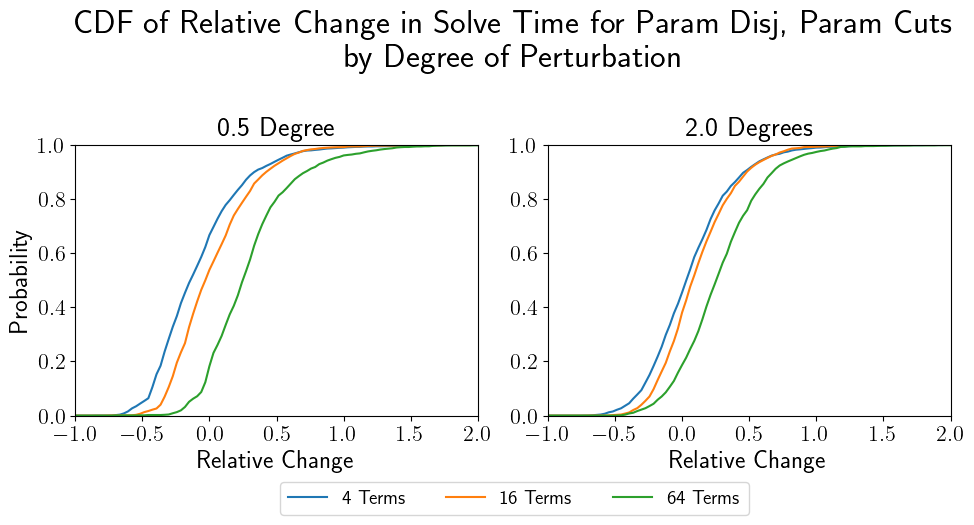

In [102]:
plot_distributions_by_parameter(gap_df, "terminationTime", plot_by='terms', title_x=.5315)

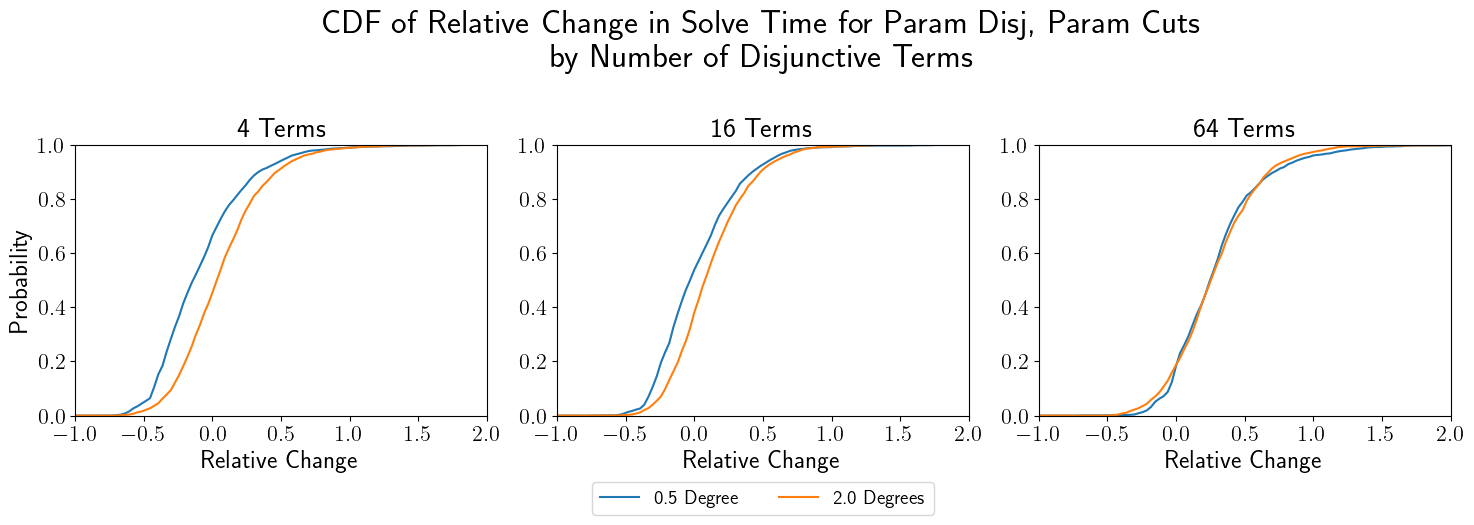

In [103]:
plot_distributions_by_parameter(gap_df, "terminationTime", plot_by='degree', title_x=.52)

In [104]:
def rename_cols(cols, feature):
    new_cols = []
    for col in cols:
        if f"{feature}Win" in col:
            col = col.replace(f"{feature}Win", f"{label[feature]} Win % ")
        elif "instanceIndex" in col:
            col = col.replace("instanceIndex", "Test Instances")
        elif "instance" in col:
            col = col.replace("instance", "Base Instances")
        new_cols.append(col)
    return new_cols

In [105]:
# get the win percentages for each feature on average and broken down by grouping type
features = ["nodes", "terminationTime", "terminationTimeSansVpc"]

wins = {}

for feature in features:
    
    # define aggregating operations
    aggregations = {f"{feature}WinFarkas": "mean", f"{feature}WinNone": "mean"}
    if feature == features[-1]:
        aggregations = aggregations | {"instance": "nunique", "instanceIndex": "count"}
    
    # find the average wins for the feature grouped by degree and terms
    feature_wins = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms"]).agg(aggregations)
    
    # clean up formatting
    feature_wins.columns = rename_cols(feature_wins.columns, feature)
    win_cols = [c for c in feature_wins.columns if "Win" in c]
    feature_wins[win_cols] = feature_wins[win_cols].applymap(lambda x: round(x * 100, 2))
    instance_cols = [c for c in feature_wins.columns if "instance" in c]
    feature_wins[instance_cols] = feature_wins[instance_cols].applymap(lambda x: int(x))
    
    # save the df
    wins[feature] = feature_wins
    
# bring them all together now
all_wins = pd.concat(wins.values(), axis=1)
all_wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_wins.csv"), index=False, mode="w")
all_wins

Nodes Processed Win % Farkas  Nodes Processed Win % None  \
degree terms                                                             
0.5    4                             44.33                       35.67   
       16                            50.43                       30.17   
       64                            24.50                       53.49   
2.0    4                             42.10                       42.07   
       16                            43.53                       41.03   
       64                            42.16                       38.31   

              Time Win % Farkas  Time Win % None  \
degree terms                                       
0.5    4                  54.43            22.97   
       16                 41.07            34.50   
       64                  6.97            67.81   
2.0    4                  32.50            39.13   
       16                 22.57            45.27   
       64                 10.08            70.03   

              Time (Minus VPC Generation) Win % Farkas  \
degree terms                                             
0.5    4                                         58.63   
       16                                        56.17   
       64                                        62.74   
2.0    4                                         38.23   
       16                                        42.63   
       64                                        66.07   

              Time (Minus VPC Generation) Win % None  Base Instances  \
degree terms                                                           
0.5    4                                       20.20               1   
       16                                      21.10               1   
       64                                      12.76               1   
2.0    4                                       34.03               1   
       16                                      27.10               1   
       64                                      10.98               1   

              Test Instances  
degree terms                  
0.5    4                3000  
       16               3000  
       64               2625  
2.0    4                3000  
       16               3000  
       64               1895

In [106]:
def aggregate_wins(gap_df, feature, grouping):

    def custom_key(col):
        # bump improvement columns second to win percentage columns
        offset = int("Improvement %" in col)
        # check groupings
        if 'matrix' in col or 'short' in col:
            return (2 + offset, col)
        elif 'objective' in col or 'medium' in col:
            return (4 + offset, col)
        elif 'rhs' in col or 'long' in col:
            return (6 + offset, col)    
        return (offset, col)
    
    # find the average wins for the feature grouped by degree, terms and grouping type
    win_aggregations = {f"{feature}WinFarkas": "mean", f"{feature}WinNone": "mean"}
    feature_wins = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms", grouping]).agg(win_aggregations).reset_index().pivot(
        index=['degree', 'terms'], columns=grouping, values=[f"{feature}WinFarkas", f"{feature}WinNone"]
    )
    feature_wins.columns = rename_cols([' '.join(col).strip() for col in feature_wins.columns.values], feature)
    feature_wins = feature_wins[sorted(feature_wins.columns, key=custom_key)]
    feature_wins = feature_wins.applymap(lambda x: round(x * 100, 2))
    
    # get the counts for the feature grouped by degree, terms and grouping type
    count_aggregations = {"instance": "nunique", "instanceIndex": "count"}
    feature_counts = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms", grouping]).agg(count_aggregations).reset_index().pivot(
        index=['degree', 'terms'], columns=grouping, values=["instance", "instanceIndex"]
    )
    feature_counts.columns = rename_cols([' '.join(col).strip() for col in feature_counts.columns.values], feature)
    feature_counts = feature_counts[sorted(feature_counts.columns, key=custom_key)]
    feature_counts = feature_counts.applymap(lambda x: int(x))
    
    # save wins, base instance counts, and test instance counts to csv
    feature_wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_wins_{feature}_{grouping}.csv"), index=False, mode="w")
    feature_counts.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_counts_{grouping}.csv"), index=False, mode="w")
    
    return feature_wins, feature_counts

In [107]:
wins, counts = aggregate_wins(gap_df, "terminationTimeSansVpc", "bracket")
wins

Time (Minus VPC Generation) Win % Farkas short  \
degree terms                                                   
0.5    4                                               58.63   
       16                                              56.17   
       64                                              62.74   
2.0    4                                               38.23   
       16                                              42.63   
       64                                              66.07   

              Time (Minus VPC Generation) Win % None short  
degree terms                                                
0.5    4                                             20.20  
       16                                            21.10  
       64                                            12.76  
2.0    4                                             34.03  
       16                                            27.10  
       64                                            10.98

In [108]:
counts

Base Instances short  Test Instances short
degree terms                                            
0.5    4                         1                  3000
       16                        1                  3000
       64                        1                  2625
2.0    4                         1                  3000
       16                        1                  3000
       64                        1                  1895

In [109]:
wins, counts = aggregate_wins(gap_df, "terminationTimeSansVpc", "perturbation")
wins

Time (Minus VPC Generation) Win % Farkas matrix  \
degree terms                                                    
0.5    4                                                73.10   
       16                                               60.20   
       64                                               68.80   
2.0    4                                                43.60   
       16                                               40.30   
       64                                               54.17   

              Time (Minus VPC Generation) Win % None matrix  \
degree terms                                                  
0.5    4                                              11.40   
       16                                             17.90   
       64                                              7.20   
2.0    4                                              31.50   
       16                                             28.30   
       64                                             16.83   

              Time (Minus VPC Generation) Win % Farkas objective  \
degree terms                                                       
0.5    4                                                  43.10    
       16                                                 38.80    
       64                                                 54.19    
2.0    4                                                  32.50    
       16                                                 47.60    
       64                                                 76.38    

              Time (Minus VPC Generation) Win % None objective  \
degree terms                                                     
0.5    4                                                 34.30   
       16                                                31.10   
       64                                                23.13   
2.0    4                                                 35.20   
       16                                                22.80   
       64                                                 6.33   

              Time (Minus VPC Generation) Win % Farkas rhs  \
degree terms                                                 
0.5    4                                             59.70   
       16                                            69.50   
       64                                            65.50   
2.0    4                                             38.60   
       16                                            40.00   
       64                                            61.22   

              Time (Minus VPC Generation) Win % None rhs  
degree terms                                              
0.5    4                                           14.90  
       16                                          14.30  
       64                                           7.60  
2.0    4                                           35.40  
       16                                          30.20  
       64                                          12.44

In [110]:
counts

Base Instances matrix  Test Instances matrix  \
degree terms                                                 
0.5    4                          1                   1000   
       16                         1                   1000   
       64                         1                    875   
2.0    4                          1                   1000   
       16                         1                   1000   
       64                         1                    600   

              Base Instances objective  Test Instances objective  \
degree terms                                                       
0.5    4                             1                      1000   
       16                            1                      1000   
       64                            1                       895   
2.0    4                             1                      1000   
       16                            1                      1000   
       64                            1                       885   

              Base Instances rhs  Test Instances rhs  
degree terms                                          
0.5    4                       1                1000  
       16                      1                1000  
       64                      1                 855  
2.0    4                       1                1000  
       16                      1                1000  
       64                      1                 410